In [47]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier

pd.options.display.max_columns = 200

In [2]:
train = pd.read_csv('/Users/botanovaolga/Desktop/mipt/ML/Task 2/data/application_train.csv')
test = pd.read_csv('/Users/botanovaolga/Desktop/mipt/ML/Task 2/data/application_test.csv')
sample_submission = pd.read_csv('/Users/botanovaolga/Desktop/mipt/ML/Task 2/data/sample_submission.csv')

In [3]:
train['dataset'] = 'train'
test['dataset'] = 'test'
y = train[['TARGET']]
x = pd.concat([train.drop(columns = 'TARGET'), test], ignore_index = True)

In [4]:
x['OWN_CAR_AGE'] = x['OWN_CAR_AGE'].fillna(0)

def categorial_fillna(df, column_name):
    counter = {}
    categories = df[df[column_name].isna() == False][column_name].unique()
    for i in categories:
        counter[i] = df[df[column_name] == i][column_name].count() / df[df[column_name].isna() == False][column_name].count()
        
    probability = [*counter.values()]
    df[[column_name]] = df[[column_name]].apply(lambda x: x.fillna(np.random.choice(categories, p = probability)), axis=1)
            

categorial_fillna(x, 'NAME_TYPE_SUITE')
categorial_fillna(x, 'OCCUPATION_TYPE')

In [5]:
enc = OneHotEncoder(drop = 'first')
enc.fit(x[['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE',
            'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']])
encoded_features = pd.DataFrame(enc.transform(x[['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']]).toarray(), 
                    columns = enc.get_feature_names(['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']))
encoded_features['SK_ID_CURR'] = x['SK_ID_CURR']
x = x.drop(columns = ['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 
                        'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                      'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])
x = x.merge(encoded_features, on = 'SK_ID_CURR')

In [6]:
x[['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']] = x[['AMT_ANNUITY', 
    'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 
                        'AMT_REQ_CREDIT_BUREAU_YEAR']].apply(lambda x: x.fillna(round(x.mean())),axis=0)

In [7]:
x = x.drop(columns = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 
                      'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 
                      'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 
                      'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
                      'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 
                      'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 
                      'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
                      'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 
                      'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 
                      'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
                      'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 
                       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'WEEKDAY_APPR_PROCESS_START', 
                      'HOUR_APPR_PROCESS_START'])

In [8]:
train = x[x['dataset'] == 'train'].drop(columns = ['SK_ID_CURR', 'dataset'])
test = x[x['dataset'] == 'test'].drop(columns = ['SK_ID_CURR', 'dataset'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y, test_size=0.33, random_state=42)

In [10]:
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_OWN_CAR_Y,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_

#### 1. Варьируем max_depth

Чем глубже дерево, тем хуже скор. Вероятно этот параметр значительно влияет на переобучение

In [11]:
column_names = ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
                'AMT_GOODS_PRICE', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 
               'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 
               'NAME_EDUCATION_TYPE_Secondary / secondary special', 'AMT_CREDIT', 'AMT_ANNUITY']

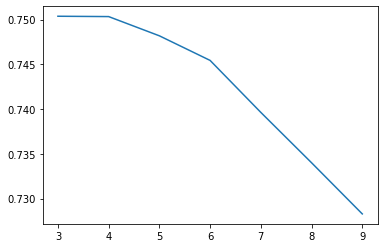

In [12]:
import warnings
warnings.filterwarnings('ignore')

max_depth = []
depth_range = range(3, 10, 1)

for depth in depth_range:
    clf1 = xgb.XGBClassifier(max_depth = depth)
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    max_depth.append(roc_auc_score(y_test, predict1))

plt.plot(depth_range, max_depth)

#### 2. Количество деревьев

После 40 дополнительное количество деревьев не сильно влияет на результат

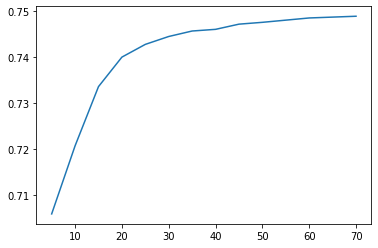

In [13]:
n_estimators = []
n_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70]

for n in n_range:
    clf1 = xgb.XGBClassifier(max_depth = 3, n_estimators = n)
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    n_estimators.append(roc_auc_score(y_test, predict1))

plt.plot(n_range, n_estimators)

 #### 3. Learning rate

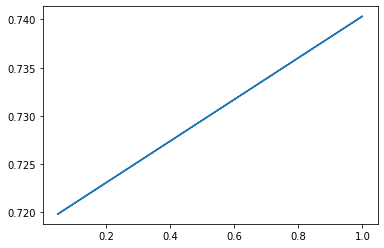

In [14]:
learning_rate = []
rate_range = (0.05, 1, 0.05)

for rate in rate_range:
    clf1 = xgb.XGBClassifier(max_depth = 3, n_estimators = 60, learning_rate = rate)
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    learning_rate.append(roc_auc_score(y_test, predict1))

plt.plot(rate_range, learning_rate)

### GridSearch
С learning rate перебор идет слишком долго, поэтому оставила только два параметра

In [16]:
classifier = xgb.XGBClassifier()
parameters = {
    'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50, 60],
    'max_depth': range(2, 10, 1)
}

grid_cv = GridSearchCV(classifier, parameters, scoring = 'roc_auc', cv = 5)

In [17]:
grid_cv.fit(X_train[column_names], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [18]:
grid_cv.best_score_

0.7469735220615987

In [19]:
grid_cv.best_params_

{'max_depth': 3, 'n_estimators': 60}

### RandSearch

In [21]:
classifier = xgb.XGBClassifier()
parameters = {
    'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50, 60],
    'max_depth': range(2, 10, 1)
}

grid_cv = RandomizedSearchCV(classifier, parameters, scoring = 'roc_auc', cv = 5)

In [22]:
grid_cv.fit(X_train[column_names], y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                          

In [23]:
grid_cv.best_score_

0.7449340807392366

In [24]:
grid_cv.best_params_

{'n_estimators': 30, 'max_depth': 4}

## Feature importance

In [42]:
column_names = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE',
 'FLAG_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_OWN_CAR_Y', 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Married']

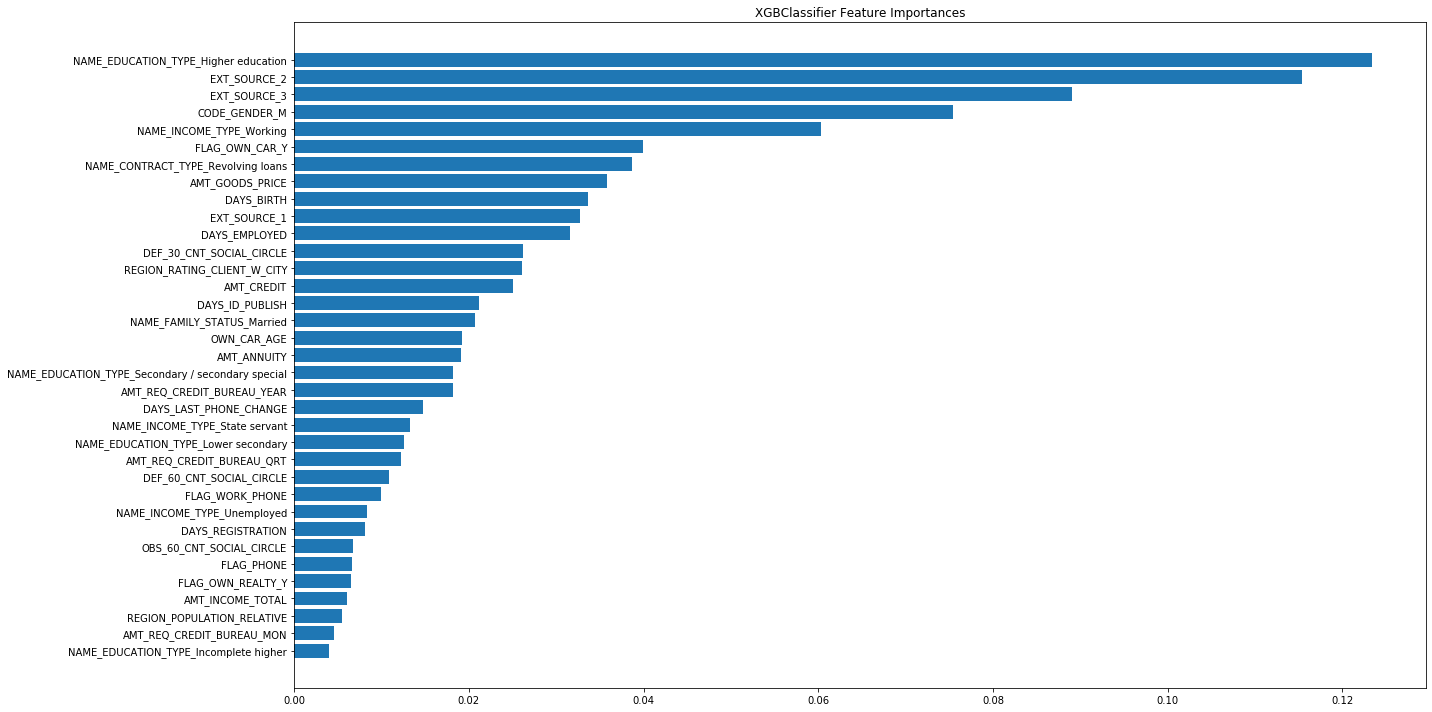

In [43]:
features = np.r_[train[column_names].columns]
clf1 = xgb.XGBClassifier(max_depth = 3, n_estimators = 60)
clf1.fit(train[column_names], y)

importance_id = clf1.feature_importances_.argsort()

y_ticks = np.arange(0, len(features))
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(y_ticks, clf1.feature_importances_[importance_id])
ax.set_yticklabels(features[importance_id])
ax.set_yticks(y_ticks)
ax.set_title("XGBClassifier Feature Importances")
fig.tight_layout()
plt.show()



Для фич со значимостью выше 0,02 скор следующий:

In [44]:
column_names = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE',
 'FLAG_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT']

clf1 = xgb.XGBClassifier(max_depth = 3, n_estimators = 60)
clf1.fit(X_train[column_names], y_train)
predict1 = clf1.predict_proba(X_test[column_names])[:,1]
roc_auc_score(y_test, predict1)

0.748533547613776

### Стекинг

In [57]:
estimators = [
        ('rf', RandomForestClassifier(n_estimators = 20, max_depth = 9)),
        ('dt', DecisionTreeClassifier(max_depth = 7, criterion = 'entropy')),
        ('sgd', SGDClassifier(loss = 'log')),
        ('lgbm', LGBMClassifier(n_estimators = 50, max_depth = 3))
    ]

clf = StackingClassifier(
        estimators = estimators, final_estimator = xgb.XGBClassifier(max_depth = 3, n_estimators = 60)
    )

In [58]:
clf.fit(X_train[column_names], y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=9,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                        

In [59]:
clf.score(X_test[column_names], y_test)

0.9199735905950985

#### Если убрать xgboosdt и оставить случайный лес как final_etimator, то скор практически не изменится

In [67]:
estimators = [
        ('dt', DecisionTreeClassifier(max_depth = 7, criterion = 'entropy')),
        ('sgd', SGDClassifier(loss = 'log')),
        ('lgbm', LGBMClassifier(n_estimators = 50, max_depth = 3))
    ]

clf = StackingClassifier(
        estimators = estimators, final_estimator = RandomForestClassifier(n_estimators = 20, max_depth = 9)
    )

In [68]:
clf.fit(X_train[column_names], y_train)

StackingClassifier(cv=None,
                   estimators=[('dt',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=7,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                     

In [69]:
clf.score(X_test[column_names], y_test)

0.9196582544171701